In [ ]:
# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №2 - Алгоритмы кластеризации

**Срок сдачи:** 17 марта 2017 (РК), 06:00

In [5]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt

import matplotlib.pyplot as plt
import mpl_toolkits.basemap as bm

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Реализация алгоритма

In [6]:
data_df = pd.read_csv("places.csv", sep=",", header=0, index_col=0, encoding='utf-8')

In [7]:
x = data_df[['latitude', 'longitude']].values

Алгоритм кластеризации, который необходимо реализовать, выбирается на основании Вашего порядкового номера в списке группы.

28 Крылов Иван

In [5]:
N = 28

In [6]:
algorithms = [
    u"Gaussian Mixture Model с использованием maximum a-posteriori для выбора кластера (параметр - k)",
    u"Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - k, linkage)",
    u"DBSCAN. (параметры - epsilon, min_pts)", 
    u"OPTICS. (параметры - epsilon, min_pts)"
]

my_algorithm = algorithms[N % len(algorithms)]
print u"Реализуем алгоритм кластеризации '%s'" % my_algorithm

Реализуем алгоритм кластеризации 'Gaussian Mixture Model с использованием maximum a-posteriori для выбора кластера (параметр - k)'


Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`

In [83]:
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.cluster import KMeans

class Clustering(BaseEstimator, ClusterMixin):
    """
    Implement clustering algorithm according 
    """
    
    def _multivar_norm_pdf(self,X,Mu,Sigma):
        return (
            (2*np.pi)**(-self.D/2)
            * (np.linalg.det(Sigma))**(-1/2)
            * np.exp(
                -1/2
                * (X-Mu).T.dot(np.linalg.inv(Sigma)).dot(X-Mu)
            )
        )
    
    def __init__(self, k, epsilon=0.0009, max_iter=100):
        """
        Please add necessary algoritm parameters to class constructor.
        """
        self.K = k # number of components/centroids
        self.epsilon = epsilon # convergence criterion
        self.max_iter = max_iter # else, stop after max_iter
        return
    
    def _fill_gamma(self,gamma,X): # E-step
        for n in xrange(self.N):
            for k in xrange(self.K):
                gamma[n,k] = (
                    self._pi[k] * self._multivar_norm_pdf(X[n],self.Mu[k],self.Sigma[k])
                    / sum(
                        map(
                            lambda j: self._pi[j] * self._multivar_norm_pdf(X[n],self.Mu[j],self.Sigma[j]),
                            xrange(self.K)
                        )
                    )
                )

    
    def _step_M(self,X): # M-step
        for k in xrange(self.K):
            self._N[k] = np.sum(self.gamma[:,k])
            self.Mu[k] = 1/self._N[k] * sum(map(
                lambda n: self.gamma[n,k] * X[n],
                xrange(self.N)
            ))
            self.Sigma[k] = 1/self._N[k] * np.sum(
                map(
                    lambda n: self.gamma[n,k] * np.dot(
                        np.matrix(X[n] - self.Mu[k]).T,
                        np.matrix(X[n] - self.Mu[k])
                    ),
                    xrange(self.N)
                ),
                axis=0
            )
            self._pi = self._N / self.N

    def _check_converged(self,old_mu,new_mu,old_sigma,new_sigma):
        for (old, new) in ((old_mu, new_mu), (old_sigma, new_sigma)):
                if np.sqrt(np.sum((new - old)**2)/(np.sum(old)**2)) >= self.epsilon:
                    return False
        return True

    def fit(self, x, y=None):
        """
        Use data matrix x to compute model parameters
        """
        self.N, self.D = x.shape
        
        init = KMeans(n_clusters=self.K).fit(x)
        self.Mu = init.cluster_centers_ # means / centroids
        self.gamma = np.empty((self.N, self.K)) # ownership weight / aposteriori probabilities
        for i in xrange(self.N):
            self.gamma[i,:] = 0
            self.gamma[i,init.labels_[i]] = 1
        
        # to be filled by M-step
        self._N = np.empty(self.K) # N_k
        self._pi = np.empty(self.K) # pi_k = mixing / apriori probabilities
        self.Sigma = np.empty((self.K,self.D,self.D)) # covariances
        self._step_M(x)
        
        for i in xrange(self.max_iter):
            old_mu = np.copy(self.Mu)
            old_sigma = np.copy(self.Sigma)
            self._fill_gamma(self.gamma,x)
            self._step_M(x)
            if self._check_converged(old_mu, self.Mu, old_sigma, self.Sigma):
                break
        
        return self
    
    def predict(self, x):
        """
        Using computed model parameters predict cluster
        for all objects from x
        """
        ap = np.empty((len(x), self.K)) # aposteriori probabilities
        labels = np.empty(len(x)) # labels to return
        self._fill_gamma(ap,x)
        for point in xrange(0,len(x)): # assign labels by max(probability)
            labels[point] = ap[point,:].argsort()[-1]

        return labels

    def fit_predict(self, x, y=None):
        self.fit(x, y)
        return self.predict(x)

Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

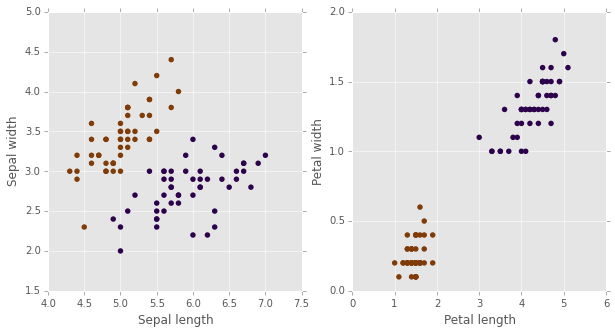

In [49]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики отличается от 1, предлагается поработать над улучшением реализации своего алгоритма.

In [84]:
pred_iris = Clustering(2,max_iter=5).fit_predict(x_iris)
print "Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris)

Adjusted Rand index for iris is: 1.00


Выбрать и реализовать критерий качества, на основании которого будут подбираться параметры модели. Варианты критериев:
- Инерция (сумма квадратов расстояний от каждой из точек до ближайшего к этой точке центроида)
- Средний диаметр (максимальное расстояние между точками в кластере) или радиус (расстояние от центроида до самой дальней от него точки в кластере)
- Sihouette

**Критерий качества необходимо выбрать таким образом, чтобы он подходил для реализованного алгоритма**

In [10]:
def quality(x, y):
    """
    Inertia
    """
    return NaN

Применим критерий для выбора параметров алгоритма. Предлагается изменить следующий код таким образом, чтобы кластеризация вызывалась с верным набором параметров. На графике можно будет увидеть зависимость критерия от параметров алгоритма. Необходимо выбрать оптимальные значения этих параметров.

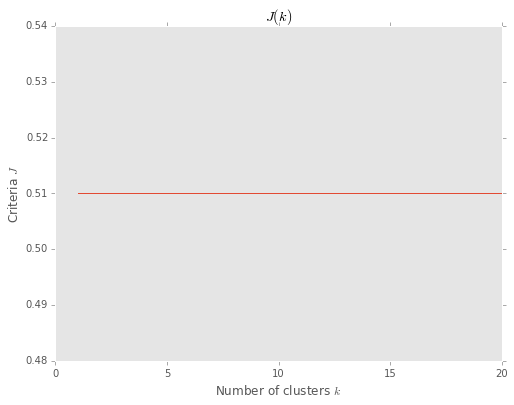

In [11]:
ks = range(1, 21)
criteria = np.zeros(len(ks))

for i, k in enumerate(ks):
    cls = Clustering()
    y = cls.fit_predict(x)
    criteria[i] = quality(x, y)
    
pl.figure(figsize=(8, 6))
pl.plot(ks, criteria)
pl.title("$J(k)$")
pl.ylabel("Criteria $J$")
pl.xlabel("Number of clusters $k$")
pl.grid()
pl.show()

Далее необходимо кластеризовать данные, используя выбранное количество кластеров, и визуализировать результат с помощью T-SNE. Внимание! На полном объеме данных данный алгоритм может работать существенное время. 

In [85]:
k = 5
cls = Clustering(k)
%time y = cls.fit_predict(x)

CPU times: user 48.9 s, sys: 4 ms, total: 48.9 s
Wall time: 48.9 s


Визуализируем кластеризацию на карте

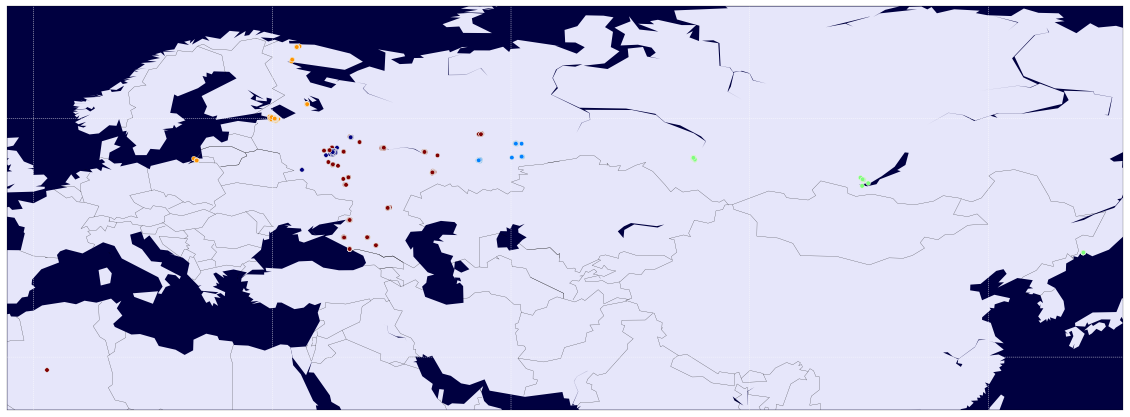

In [42]:
pl.figure(figsize=(20,12))

m = bm.Basemap(projection='cyl', llcrnrlat=min(x[:, 0]) - 5, urcrnrlat=max(x[:, 0]) + 5, llcrnrlon=min(x[:, 1]) - 5, urcrnrlon=max(x[:, 1]) + 5, resolution='c')

m.drawcountries(linewidth=0.2)
m.fillcontinents(color='lavender', lake_color='#000040')
m.drawmapboundary(linewidth=0.2, fill_color='#000040')
m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0], color='white', linewidth=0.5)
m.drawmeridians(np.arange(0,360,30),labels=[0,0,0,0], color='white', linewidth=0.5)

m.scatter(x[:, 1], x[:,0], c=y, zorder=10)
    
pl.show()

Визуализируйте интересные участки (может быть это Москва) в приближенном виде. Постройте 3 (или более, в зависимости от данных, что вам самим бы хотелось увидеть ближе) увеличенных изображений карты с кластеризацией.

In [10]:
import folium as fl
# your code with maps here

Какой вывод можно сделать о качестве кластеризации?

Поздравляем, Вы завершили домашние задания по модулю "Алгоритмы кластеризации". Надеемся, что это было интересно.